In [1]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

from vocab import Vocab
from dataset import Paint2CodeDataset
from utils import collate_fn, save_model, resnet_img_transformation
from models import Encoder, Decoder

In [2]:
# Set parameters
data_path = Path("data", "all_data")
vocab_file_path = None or Path(data_path.parent, "vocab.txt")
use_cuda = True  
img_crop_size = 224
save_after_epochs = 5
models_dir = Path("models")
batch_size = 4
epochs = 30
lr = 0.001
seed = 42

# Seed setup for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
vocab = Vocab(vocab_file_path)
assert len(vocab) > 0, "Vocabulary must be non-empty"

print(vocab)

{
  "START": 0,
  "END": 1,
  "PADDING": 2,
  "UNKNOWN": 3,
  ",": 4,
  "btn-body": 5,
  "btn-header": 6,
  "double": 7,
  "header": 8,
  "image": 9,
  "quadruple": 10,
  "row": 11,
  "single": 12,
  "small-title": 13,
  "text": 14,
  "{": 15,
  "}": 16
}


In [4]:
# Setup GPU for training
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Define image transformation using the ResNet specs
transform_imgs = resnet_img_transformation(img_crop_size)

train_loader = DataLoader(
    Paint2CodeDataset(data_path, "train", vocab, transform=transform_imgs),
    batch_size=batch_size,
    collate_fn=lambda data: collate_fn(data, vocab=vocab),
    pin_memory=True if use_cuda else False,
    drop_last=True
)
print("Data loader for train created successfully.")

test_loader = DataLoader(
    Paint2CodeDataset(data_path,"test", vocab, transform=transform_imgs),
    batch_size=batch_size,
    collate_fn=lambda data: collate_fn(data, vocab=vocab),
    pin_memory=True if use_cuda else False,
    drop_last=True
)
print("Data loader for test created successfully.")

Data loader for train created successfully.
Data loader for test created successfully.


In [6]:
# Model parameters
embed_size = 256
hidden_size = 512
num_layers = 1

# Initialize the Encoder and Decoder
encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

print("Models are initialized and moved to the designated device.")

Models are initialized and moved to the designated device.


In [7]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.BatchNorm.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

print("Loss function and optimizer are set.")

Loss function and optimizer are set.


In [8]:
# Initialize lists to store the average losses per epoch
train_losses = []
test_losses = []

print("Starting training...")
for epoch in range(epochs):
    # Training phase
    encoder.train()  # Set the encoder to training mode
    decoder.train()  # Set the decoder to training mode
    total_train_loss = 0
    num_batches = 0

    for images, captions, lengths in train_loader:
        images = images.to(device)
        captions = captions.to(device)
        targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Zero the gradients
        encoder.zero_grad()
        decoder.zero_grad()

        # Forward pass
        features = encoder(images)
        output = decoder(features, captions, lengths)

        # Calculate loss
        loss = criterion(output, targets)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        num_batches += 1

    avg_train_loss = total_train_loss / num_batches
    train_losses.append(avg_train_loss)  # Append the average training loss

    # Testing phase
    encoder.eval()  # Set the encoder to evaluation mode
    decoder.eval()  # Set the decoder to evaluation mode
    total_test_loss = 0
    num_test_batches = 0

    with torch.no_grad():  # No need to track gradients during testing
        for images, captions, lengths in test_loader:
            images = images.to(device)
            captions = captions.to(device)
            targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Forward pass
            features = encoder(images)
            output = decoder(features, captions, lengths)

            # Calculate loss
            loss = criterion(output, targets)
            total_test_loss += loss.item()
            num_test_batches += 1

    avg_test_loss = total_test_loss / num_test_batches
    test_losses.append(avg_test_loss)  # Append the average testing loss

    # Print integrated loss statistics in one line
    print(f'Epoch {epoch}: Training Loss {avg_train_loss:.3f}, Test Loss {avg_test_loss:.3f}')

    #Save model checkpoint
    if epoch != 0 and epoch % save_after_epochs == 0:
        save_model(models_dir, encoder, decoder, optimizer, epoch, avg_train_loss, batch_size, vocab)
        print("Saved model checkpoint at epoch:", epoch)

print("Training completed!")

Starting training...
Epoch 0: Training Loss 0.248, Test Loss 0.121
Epoch 1: Training Loss 0.111, Test Loss 0.103
Epoch 2: Training Loss 0.104, Test Loss 0.105
Epoch 3: Training Loss 0.100, Test Loss 0.096
Epoch 4: Training Loss 0.095, Test Loss 0.097
Epoch 5: Training Loss 0.092, Test Loss 0.122
Saved model checkpoint at epoch: 5
Epoch 6: Training Loss 0.088, Test Loss 0.088
Epoch 7: Training Loss 0.085, Test Loss 0.107
Epoch 8: Training Loss 0.081, Test Loss 0.086
Epoch 9: Training Loss 0.078, Test Loss 0.083
Epoch 10: Training Loss 0.075, Test Loss 0.087
Saved model checkpoint at epoch: 10
Epoch 11: Training Loss 0.070, Test Loss 0.088
Epoch 12: Training Loss 0.067, Test Loss 0.107
Epoch 13: Training Loss 0.064, Test Loss 0.118
Epoch 14: Training Loss 0.063, Test Loss 0.136
Epoch 15: Training Loss 0.058, Test Loss 0.124
Saved model checkpoint at epoch: 15
Epoch 16: Training Loss 0.054, Test Loss 0.170
Epoch 17: Training Loss 0.051, Test Loss 0.183
Epoch 18: Training Loss 0.049, Test 

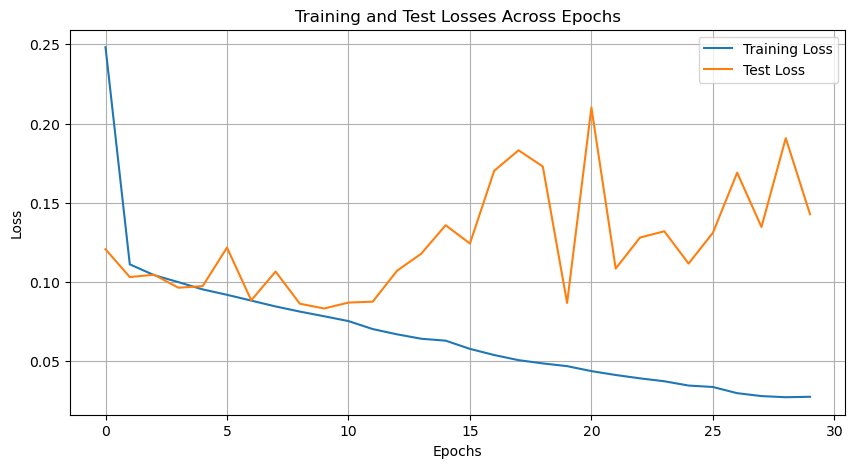

In [9]:
# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Losses Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
#Save the final model
save_model(models_dir, encoder, decoder, optimizer, epochs*10, loss.item(), batch_size, vocab)
print("Final model saved.")

Final model saved.
